# TauREx Retrievals

We will use this notebooks to introduce ourselves to running retrievals in TauREx.

We will first setup, ``taurex`` and its opacities, we will use the [ExoTransmit] one as we are aiming for speed and they are okay to use for these purposes.

In [1]:
!pip install taurex


#### ExoTransmit
! git clone https://github.com/elizakempton/Exo_Transmit.git

!mkdir cia

!wget https://hitran.org/data/CIA/H2-H2_2011.cia -P ./cia
!wget https://hitran.org/data/CIA/H2-He_2011.cia -P ./cia


fatal: destination path 'Exo_Transmit' already exists and is not an empty directory.
mkdir: cannot create directory ‘cia’: File exists
--2025-02-12 21:26:28--  https://hitran.org/data/CIA/H2-H2_2011.cia
Resolving hitran.org (hitran.org)... 131.142.195.62
Connecting to hitran.org (hitran.org)|131.142.195.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24824179 (24M)
Saving to: ‘./cia/H2-H2_2011.cia.2’

H2-H2_2011.cia.2    100%[===================>]  23.67M  57.2MB/s    in 0.4s    

2025-02-12 21:26:29 (57.2 MB/s) - ‘./cia/H2-H2_2011.cia.2’ saved [24824179/24824179]

--2025-02-12 21:26:29--  https://hitran.org/data/CIA/H2-He_2011.cia
Resolving hitran.org (hitran.org)... 131.142.195.62
Connecting to hitran.org (hitran.org)|131.142.195.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146854122 (140M)
Saving to: ‘./cia/H2-He_2011.cia.2’

H2-He_2011.cia.2    100%[===================>] 140.05M  38.2MB/s    in 3.7s    

2025-02-12 21:26:

We will now prepare our caches as well:



In [2]:
from taurex.cache import OpacityCache, CIACache

OpacityCache().set_opacity_path('Exo_Transmit/Opac')
CIACache().set_cia_path('./cia/')

# Observations

In TauREx, ``observations`` or ``spectra`` refer to the empirical spectra of exoplanet atmospheres that we aim to model and interpret.

We should start by acquiring some data first:

In [3]:
!wget https://raw.githubusercontent.com/ucl-exoplanets/taurex3/refs/heads/main/examples/parfiles/quickstart.dat

--2025-02-12 21:26:37--  https://raw.githubusercontent.com/ucl-exoplanets/taurex3/refs/heads/main/examples/parfiles/quickstart.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10752 (10K) [text/plain]
Saving to: ‘quickstart.dat.2’

quickstart.dat.2    100%[===================>]  10.50K  --.-KB/s    in 0s      

2025-02-12 21:26:37 (60.5 MB/s) - ‘quickstart.dat.2’ saved [10752/10752]



The ``taurex.spectrum`` module contains many classes that handle loading of spectral data in TauREx.

Some of these include:

- ``ArraySpectrum``
  - Spectra composed of at least ``wavelength``, ``spectra`` and ``error`` arrays
- ``ObservedSpectrum``
  - Loaded from a 3-4 column file
- ``IraclisSpectrum``
  - Spectra loaded from [iraclis](https://github.com/ucl-exoplanets/Iraclis)


As we have a text file, we can use the ``ObservedSpectrum`` to load it in.

In [4]:
from taurex.spectrum import ObservedSpectrum

obs = ObservedSpectrum("./quickstart.dat")

Lets plot the spectrum:

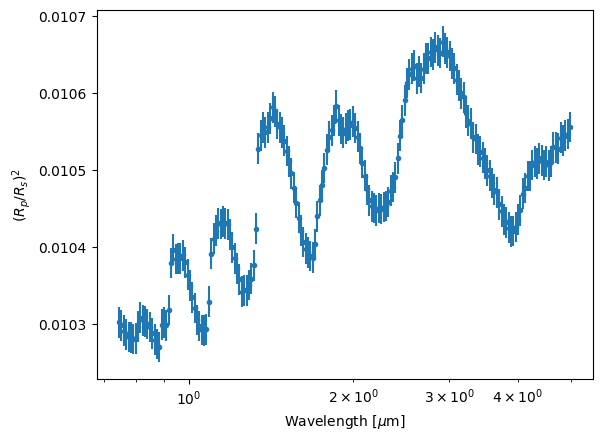

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.errorbar(obs.wavelengthGrid, obs.spectrum, yerr=obs.errorBar, fmt='.')
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("$(R_p/R_s)^2$")
plt.xscale("log")
plt.show()

# Binning Models

Lets build a forward model to try and figure out what the atmosphere contains.

In [6]:
from taurex.temperature import Isothermal
from taurex.planet import Planet
from taurex.stellar import BlackbodyStar
from taurex.chemistry import TaurexChemistry, ConstantGas
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution, RayleighContribution, CIAContribution

isothermal = Isothermal(T=1500.0)

chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

chemistry.addGas(ConstantGas('H2O',mix_ratio=1.2e-4))
chemistry.addGas(ConstantGas('N2',mix_ratio=3.00739e-9))

tm = TransmissionModel(planet=Planet(planet_radius=1.0,planet_mass=1.0),
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=BlackbodyStar(temperature=5700.0,radius=1.0),
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())
tm.build()

We can plot the transit model against the spectra.

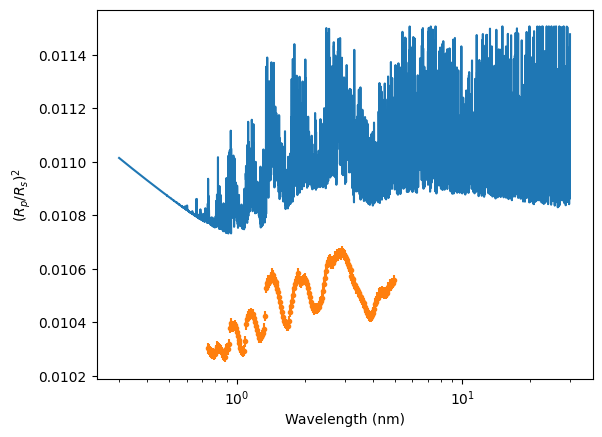

In [7]:
wngrid, rprs, tau, _ = tm.model()

wlgrid = 10000/wngrid[::-1]
rprs = rprs[::-1]

plt.figure()
plt.plot(wlgrid, rprs, label="TauREx")
plt.errorbar(obs.wavelengthGrid, obs.spectrum, yerr=obs.errorBar, fmt='.', label="Obs.")
plt.xscale('log')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$(R_p/R_s)^2$')
plt.show()

Now our model is of a much higher resolution than the observation. What we need to do is bin it down to the correct resolution. Fortunately, the ``Observation`` contains a ``create_binner`` function that creates a ``Binner`` object.

## Binners

Binners in TauREx are used to bin down higher resolution spectra into lower resolutions. Generally this is done by averaging the spectra in the new wavelength bin but ``taurex`` provides the ``FluxBinner`` which should take into consideration spectra that falls between two wavelength bins.


Fortunately this is the default and we can simply invoke it from the observation rather than creating one from scratch:

In [8]:
binner = obs.create_binner()

Now we can model and bin it down to the correct resolution:

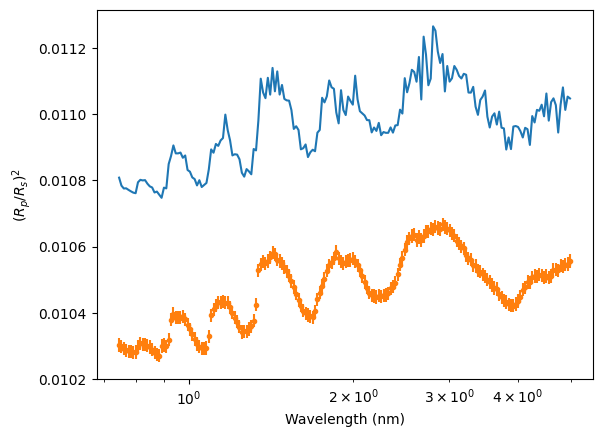

In [9]:
wngrid, rprs, tau, _ = binner.bin_model(tm.model())

wlgrid = 10000/wngrid[::-1]
rprs = rprs[::-1]

plt.figure()
plt.plot(wlgrid, rprs, label="TauREx")
plt.errorbar(obs.wavelengthGrid, obs.spectrum, yerr=obs.errorBar, fmt='.', label="Obs.")
plt.xscale('log')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$(R_p/R_s)^2$')
plt.show()

Much better! Now we have a good understanding on how we arrive to roughly the correct spectra. Now we can move onto the meat and potatoes. *Retrievals*

# Retrievals

All of the modelling we have done solves the forward problem, which is fairly easy in the grand scheme of things. Effectively we ask:
```
If I have an atmosphere that is around 1000 K and has a bit of water, what does the spectra look like?
```
A harder question would be:
```
I have a spectra that looks like this, how much water and how hot is it?
```

This is the **inverse** problem and it is what retrievals in TauREx are built to do. Retrievals require 4 ingredients:

- A model to fit
- An observation to fit
- The parameters and their distributions
- The samplers.

The main sampling method is Nested Bayesian Sampling but other samplers such as [emcee](https://pypi.org/project/taurex-emcee/) are available *via plugins*

Nested Sampling allows us to efficiently compute the marginal likelihood (Bayesian evidence $Z$) and the posterior distribution $P(\theta|x,M)$ where $\theta$ are our model parameters given data $x$ assuming model $M$. This fits in the classic Bayesian argument:

$$
P(\theta|x,M) = \frac{P(x|\theta,M)\cdot P(\theta,M)}{Z}
$$


TauREx comes prepacked with [nestle](http://kylebarbary.com/nestle/) which is a nested sampler but other samplers like [Multinest](https://github.com/JohannesBuchner/MultiNest) and [ultranest](https://github.com/JohannesBuchner/ultranest) can be enable if installed with the appropriate librares or plugins.

## Discovering fittable parameters.

In the [TauREx-Modelling](https://colab.research.google.com/drive/1RppsquYSrQeHdmjDrwgjrO7DuyQTgJ6O?usp=sharing) notebook we alluded to ``fittingParameters`` allowing for the modification of atmospheric properties in the model. Well these are the fitting parameters that are available for us to fit against our observation!!! Lets look at them again:

In [10]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'N2',
 'He_H2']

These are all parameters that we can fit during a retrieval. Lets think about this as we setup our optimizer.

# Optimizer

Optimizers are the main workhorse when it comes to retrievals, their job is to coordinate the model and observation with the sampler. We've alluded to the ``nestle`` optimizer so lets create and insert our model and observation:

In [16]:
from taurex.optimizer import NestleOptimizer

opt = NestleOptimizer(observed=obs, model=tm, num_live_points=50)
opt.set_model(tm)


The *number of live points* is a hyperparameter in nested bayesian sampling which describes how fine-grained the sampling of the probability space is, we plan to fit roughly 2 parameters so roughly we do: $N_{params}\times 25$

More lives points are better but lead to slower results.

We can also observe the fitting parameters here as well:

In [17]:
list(opt.avail_fit_parameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'N2',
 'He_H2']

# Priors

In our fictional planet we observed some parameters:

- The planet radius from photometry is $\approx 1~R_{jup}$
- The irradiation temperature is roughly $T_{irr} = 1800$

For $T$ we can reasonably sample around $1000-2000~K$.

For $R_p$ we can go around $0.5-2.0~R_{jup}$

We want to fit molecules as well, given these are primary atmospheres, we can make some informed decisions on them as well.

We should make a choice on our priors. Priors reflect how the parameters are sampled:

- ``Uniform``
  - all values have equal probability
- ``LogUniform``
  - Same as unifrom but values are sampled in logspace

For $T$ and $R_{p}$, *uniform* is very suitable.

Lets import these priors and set them in the optimizer for:

- ``T``
- ``planet_radius``




In [18]:
from taurex.core.priors import Uniform, LogUniform

opt.enable_fit("T")
opt.set_prior("T", Uniform(bounds=(1000.0, 2000.0)))

opt.enable_fit("planet_radius")
opt.set_prior("planet_radius", Uniform(bounds=(0.5,2.0)))



Now we can see what has been enabled by observing ``fit_names``

In [19]:
opt.fit_names

['planet_radius', 'T']

Whats interesting is that the ``H2O`` and ``CH4`` are already prefixed with ``log`` which is a useful touch.

Now finally we can fit!

In [61]:
solution = opt.fit()

it=   654 logz=1667.440813niter: 655
ncall: 1123
nsamples: 705
logz: 1667.858 +/-  0.476
h: 11.322


The solution is a dictionary of everything output from the sampler:

In [62]:
print(solution.keys())

dict_keys(['solution0'])


Its possible that multiple solutions can occur, for now we only have one solution which is a plus!

In [63]:
print(solution['solution0'].keys())

dict_keys(['Statistics', 'fit_params', 'tracedata', 'weights', 'Spectra', 'Profiles', 'derived_params'])


Lets use a quick convienience function ``get_solution`` to plot the resultant spectra:

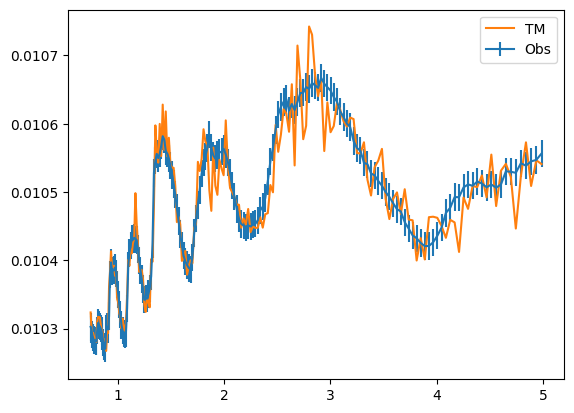

In [64]:
for sol,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
    plt.plot(obs.wavelengthGrid,binner.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.legend()
    plt.show()

# Analysing the retrieval

We have access to a lot of parameters. First the tracedata and weights are the sampled points, we can plot them using a corner plot.

First lets install corner:

In [65]:
!pip install corner

A useful function to limit the size of the posterior

In [66]:
def compute_ranges(solution):
  fit_params = solution['fit_params']
  ranges = []
  for key, val in fit_params.items():
    v = val['value']
    sm = val['sigma_m']
    sp = val['sigma_p']
    ranges.append((v-5*sm,v+5*sp))

  return ranges


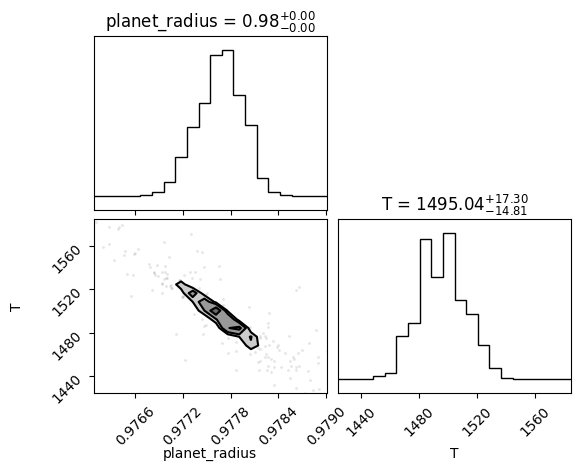

In [67]:
import corner

sol0 = solution['solution0']
fig = plt.figure()
corner.corner(data=sol0['tracedata'], weights=sol0['weights'],
              labels=list(sol0['fit_params'].keys()),
              scale_hist=True,
              bins=20,
              range=compute_ranges(sol0),  # USe the range function to focus in on the posteriors
              fill_contours=True,
              show_titles=True,
              fig=fig)
plt.show()

We can also plot the spectra uncertainties as well:

(Although they are pretty small here)

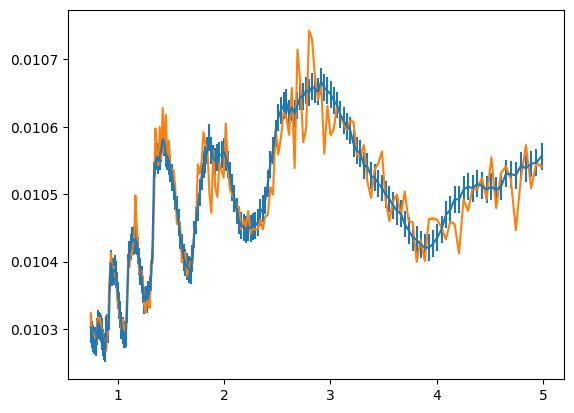

In [78]:

binned_spectrum = sol0['Spectra']['binned_spectrum']
binned_wlgrid = sol0['Spectra']['binned_wlgrid']
binned_std = sol0['Spectra']['binned_std']
color='orange'
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
plt.plot(binned_wlgrid, binned_spectrum, label='Model')
plt.fill_between(binned_wlgrid, binned_spectrum-binned_std,
                    binned_spectrum+binned_std,
                    alpha=0.5, zorder=-2, color=color, edgecolor='none')

# 2 sigma
plt.fill_between(binned_wlgrid, binned_spectrum-2*binned_std,
                    binned_spectrum+2*binned_std,
                    alpha=0.2, zorder=-3, color=color, edgecolor='none')

plt.show()

# Using the taurex program

Using the taurex program we can run the retrievals, store them and then plot them in great detail! Lets try it out. We will create an equivalent input file and store it as ``input.par``

In [88]:
%%sh
cat > input.par << EOF
[Global]
xsec_path = ./Exo_Transmit/Opac
cia_path = ./cia

[Chemistry]
chemistry_type = taurex
fill_gases = H2,He
ratio = 4.8962e-2

    [[H2O]]
    gas_type = constant
    mix_ratio=1.1185e-4

    [[N2]]
    gas_type = constant
    mix_ratio = 3.00739e-9

[Temperature]
profile_type = isothermal
T = 1265.97764826

[Pressure]
profile_type = Simple
atm_min_pressure = 1e-0
atm_max_pressure = 1e6
nlayers = 30

[Planet]
planet_type = Simple
planet_mass = 1.0
planet_radius = 0.999430455828

[Star]
star_type = blackbody
temperature = 5800

[Model]
model_type = transmission

    [[Absorption]]
    [[CIA]]
    cia_pairs = H2-H2,H2-He
    [[Rayleigh]]

[Observation]
observation = dat-file
filename = ./quickstart.dat

[Optimizer]
optimizer = nestle
num_live_points=50
method = single

[Fitting]
planet_radius:fit = True
T:fit = True
planet_radius:prior = "Uniform(bounds=(0.5,2.0))"
T:prior = "Uniform(bounds=(1000.0,2000.0))"

EOF
ls -l

total 4736
drwxr-xr-x 2 root root    4096 Feb 12 21:26 cia
drwxr-xr-x 7 root root    4096 Feb 12 21:17 Exo_Transmit
-rw-r--r-- 1 root root     927 Feb 12 22:06 input.par
-rw-r--r-- 1 root root 4789400 Feb 12 22:06 output.hdf5
-rw-r--r-- 1 root root   10752 Feb 12 16:38 quickstart.dat
-rw-r--r-- 1 root root   10752 Feb 12 21:17 quickstart.dat.1
-rw-r--r-- 1 root root   10752 Feb 12 21:26 quickstart.dat.2
drwxr-xr-x 1 root root    4096 Feb 10 14:25 sample_data
drwxr-xr-x 2 root root    4096 Feb 12 16:36 xsec


Now we run the taurex program with the arguments:

```bash
taurex -i input.par --retrieval -o output.hdf5
```

Where ``-i`` describes the input ``--retrieval`` switch taurex to retrieval mode and ``-o`` describes the output ``HDF5`` filename.

🚀**TIP**: can see the available fitparams by running:

In [89]:
!taurex -i input.par --fitparams

taurex - INFO - TauREx 3.2.0
taurex - INFO - TauREx PROGRAM START AT 2025-02-12 22:06:51.088281
taurex.ParamParser - INFO - Interpolation mode set to linear
taurex.ParamParser - WARNING - Xsecs will be loaded in memory
taurex.ParamParser - WARNING - Radis is disabled
taurex.ParamParser - WARNING - Radis default grid will be used
taurex.ClassFactory - INFO - Reloading all modules and plugins
taurex.ClassFactory - INFO - ----------Plugin loading---------
taurex.TransmissionModel - INFO - Building model........
taurex.TransmissionModel - INFO - Collecting paramters
taurex.TransmissionModel - INFO - Setting up profiles
taurex.TransmissionModel - INFO - Setting up contributions
taurex.TransmissionModel - INFO - DONE

-----------------------------------------------
------Available Retrieval Parameters-----------
-----------------------------------------------

╒══════════════════╤══════════════════════════════════════════════════════╕
│ Param Name       │ Short Desc                          

Lets run the retrieval

In [90]:
!taurex -i input.par --retrieval -o output.hdf5

taurex - INFO - TauREx 3.2.0
taurex - INFO - TauREx PROGRAM START AT 2025-02-12 22:06:57.065549
taurex.ParamParser - INFO - Interpolation mode set to linear
taurex.ParamParser - WARNING - Xsecs will be loaded in memory
taurex.ParamParser - WARNING - Radis is disabled
taurex.ParamParser - WARNING - Radis default grid will be used
taurex.ClassFactory - INFO - Reloading all modules and plugins
taurex.ClassFactory - INFO - ----------Plugin loading---------
taurex.TransmissionModel - INFO - Building model........
taurex.TransmissionModel - INFO - Collecting paramters
taurex.TransmissionModel - INFO - Setting up profiles
taurex.TransmissionModel - INFO - Setting up contributions
taurex.TransmissionModel - INFO - DONE
taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.OpacityCache - INFO - Reading opacity H2O
taurex.OpacityCache - INFO - Loading opacity H2O into model
taurex.OpacityCache - INFO - Reading opacity N2
t

Now lets plot the results using ``taurex-plot``

In [91]:
!taurex-plot -i output.hdf5 -a -o plots/

/usr/local/lib/python3.11/dist-packages/taurex/plot/corner.py:289: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(range[i])
/usr/local/lib/python3.11/dist-packages/taurex/plot/corner.py:620: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(range[1])
/usr/local/lib/python3.11/dist-packages/taurex/plot/plotter.py:529: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(wlgrid, obs_spectrum, marker='d',zorder=1,**{'s': 10, 'edgecolors': 'grey','c' : self.cmap(float(solution_idx)/N) })


Check the plot folder and see all of the retrieval results!